# Lego World Map

Code inspired from Milan Janosov to create a stylized elevation map of the world.

You can read about his work creating a Lego elevation map of Budapest [here](https://open.substack.com/pub/milanjanosov/p/lego-elevation-map?r=3mp6w8&utm_medium=ios) on his Substack.

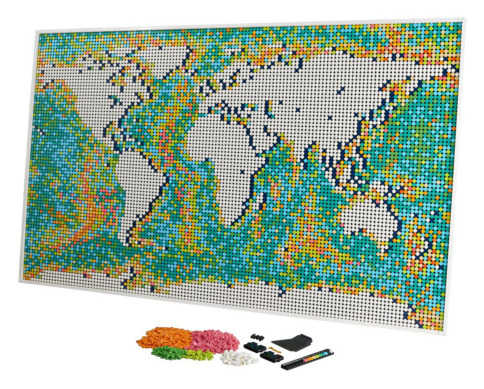

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# https://jaysbrickblog.com/wp-content/uploads/2021/05/\
# LEGO-31203-World-Map-Product-Photo-1024x815.jpg
img = mpimg.imread('figures/LEGO-31203-World-Map-Product-Photo-1024x815.jpg')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Lego has previously made a world map, but I think I could do a little better!

## Imports

In [45]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from rasterio.plot import show
from rasterio.merge import merge
import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
import sys
import subprocess
import glob
import string
from osgeo import gdal
from pathlib import Path
import os
import osmnx as ox
from shapely.geometry import box
from PIL import Image, ImageEnhance
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skimage.color import rgb2lab, lab2rgb
from sklearn.cluster import KMeans

DEM Raster data sourced from here:

https://earthexplorer.usgs.gov

## Helper Functions

In [13]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [14]:
seed=rand_gen()
seed

6250

In [15]:
# save random seed for project
with open('seed.txt', 'w') as file:
    file.write(str(seed))

In [16]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x309E67840

## Merge DEMs

In [49]:
# adapted from https://gis.stackexchange.com/questions/449569/\
# merging-a-large-number-of-geotiff-files-via-gdal-merge-py

# paths
input_folder=Path('../_data/dem_tile_world_gtopo30')
output_folder=Path('../_data')
output_file=output_folder / "dem_world_gtopo30.tiff"
vrt_file=output_folder / "merged.vrt"

# create output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# find and list all .tif files
input_files = [Path(file) for file in glob.glob(str(input_folder / '*.tif'))]
print(f"Found {len(input_files)} files to merge.")

# dictionary for temporary short names
# to manage potentially long filenames
original_names = {}
characters = string.digits + string.ascii_letters

# temporarily rename files to short names
print("Renaming files temporarily...")
for i, file in enumerate(input_files):
    new_name = f"{characters[i % len(characters)]}{characters[i // len(characters)]}.t"
    new_path = file.parent / new_name
    file.rename(new_path)
    original_names[new_path] = file

# build VRT from renamed files
print("Building VRT file...")
gdal.BuildVRT(str(vrt_file), [str(file) for file in original_names.keys()])

# translate VRT to TIFF
print("Translating VRT to TIFF...")
gdal.Translate(str(output_file), str(vrt_file))

# restore original file names
print("Restoring original file names...")
for new_path, original_path in original_names.items():
    new_path.rename(original_path)

# clean up VRT file
print("Cleaning up temporary files...")
vrt_file.unlink()

print(f"Merging completed. Final output located at: {output_file}")

Found 33 files to merge.
Renaming files temporarily...
Building VRT file...
Translating VRT to TIFF...
Restoring original file names...
Cleaning up temporary files...
Merging completed. Final output located at: ../_data/dem_world_gtopo30.tiff


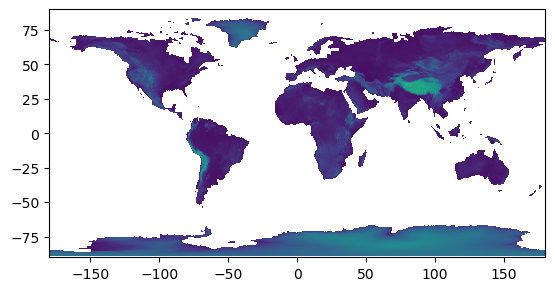

<Axes: >

In [29]:
# view file
fp=r'../_data/dem_world_gtopo30.tiff'
img=rio.open(fp)
show(img)

Saved image to ../_figs/dem_world.jpg


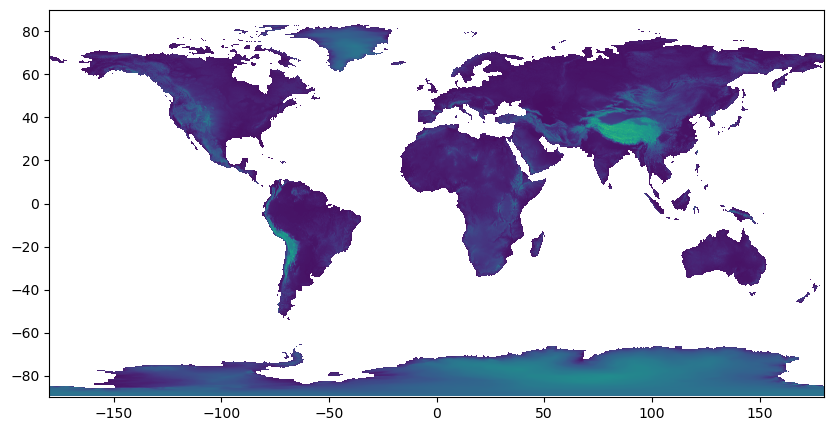

In [46]:
# save as jpg for posterity

# define paths
tiff_file=Path('../_data/dem_world_gtopo30.tiff')
output_image=Path('../_figs/dem_world.jpg')
output_image.parent.mkdir(parents=True,exist_ok=True)

# open and save as jpg
with rio.open(tiff_file) as src:
    fig,ax = plt.subplots(figsize=(10, 10))
    show(src,ax=ax)
    plt.savefig(output_image,format="jpg",dpi=300,bbox_inches='tight',pad_inches=0.1)
    
print(f'Saved image to {output_image}')

Now we have to rasterize the elevation map. This is crucial as we'll be eventually making this map in Lego, which are bricks (duh).

We need to have a look at the boundaries of the world. I have a file downloaded already:

<Axes: >

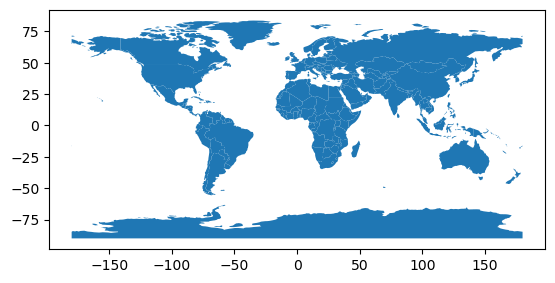

In [3]:
borders = gpd.read_file('../_data/world_borders.geojson')
borders.plot()

<Figure size 640x480 with 0 Axes>

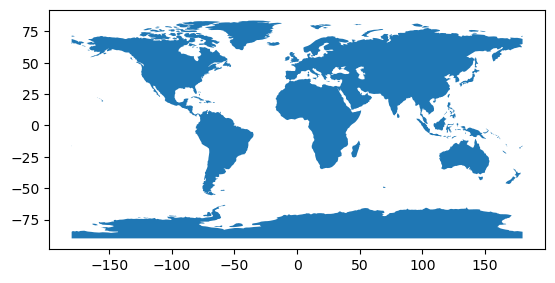

In [46]:
# merge into one mega-world-spanning polygon
world_polygon = borders.union_all()
world = gpd.GeoDataFrame(geometry=[world_polygon], crs=borders.crs)
world.to_parquet('../_data/world_polygon.parquet', engine='pyarrow')

world = gpd.read_parquet('../_data/world_polygon.parquet')
plt.figure()
world.plot()

plt.savefig('figures/world_polygon.jpg',bbox_inches='tight')

Milan made a function that split the polygon into a grid with a user-specified number of cells. We may have to adapt it as our world map is not a square.

In [4]:
# Create the grid polygons
def create_grid(minx, miny, maxx, maxy, num_cells_x, num_cells_y):
    grid_polygons = []
    cell_width = (maxx - minx) / num_cells_x
    cell_height = (maxy - miny) / num_cells_y

    for i in range(num_cells_x):
        for j in range(num_cells_y):
            x = minx + i * cell_width
            y = miny + j * cell_height
            grid_polygons.append(box(x, y, x + cell_width, y + cell_height))
    
    return grid_polygons

In [29]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
# extract the bounding box of the world from the GeoDataFrame
bounds = world.bounds

minx = bounds.minx.values[0]
miny = bounds.miny.values[0]
maxx = bounds.maxx.values[0]
maxy = bounds.maxy.values[0]

We'll have to figure out what the dimensions of the Lego set are (in Lego studs), as that is a good size for our eventual Lego map.
* The map is $5 x 16 \text{ or } 80\text{ studs }$in height
* The map is $8 x 16 \text{ or } 128\text{ studs }$in width

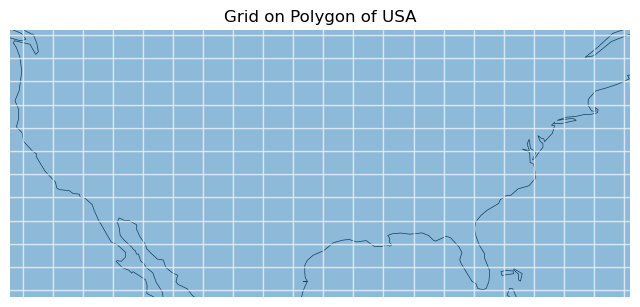

In [39]:
# Create a user-defined grid within the bounding box of the world
height = 80
width = 128
grid_crs = world.crs.to_epsg()
grid_polygons = create_grid(minx, miny, maxx, maxy, width, height)
gdf_grid = gpd.GeoDataFrame(grid_polygons, columns=['geometry'])
gdf_grid.crs = grid_crs

# Visualize the grid overlaid on the map
f, ax = plt.subplots(1, 1, figsize=(8, 8))
world.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
gdf_grid.plot(ax=ax, edgecolor='w', alpha=0.5)
ax.axis('off')

# just view USA for now
ax.set_xlim(-125, -66.9)
ax.set_ylim(24.4, 49.4)

plt.title('Grid on Polygon of USA')

plt.savefig('figures/grid_usa.jpg',bbox_inches='tight')
plt.savefig('figures/grid_usa.pdf',bbox_inches='tight')
plt.savefig('figures/grid_usa.png',bbox_inches='tight')

plt.show()

## Add surface color

We will attempt to downsample the colors of the bare earth surface to add to our lego map.

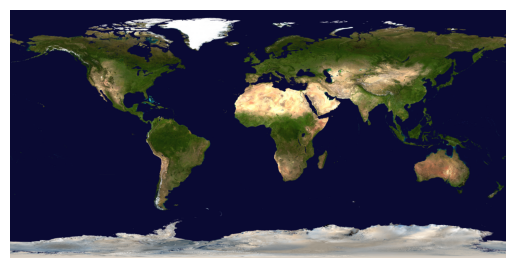

In [4]:
# https://svs.gsfc.nasa.gov/vis/a000000/a002900/a002915/bluemarble-2048.png
# thankfully this is in the same projection as our other assets
img = mpimg.imread('figures/bluemarble-2048.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

First, let's count the number of colors that the above image has.

In [12]:
# load the image and convert to RGB mode
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# convert image to a numpy array
image_array = np.array(image)

# reshape the array into a list of RGB values
pixels = image_array.reshape(-1, 3)

# count unique colors
unique_colors = np.unique(pixels, axis=0)
print(f"Number of unique colors: {len(unique_colors)}")

Number of unique colors: 220909


That's quite a large number of colors. We'll use KMeans to cluster the colors into a much smaller number. Let's see what a much reduced amount (≤15) gives us.

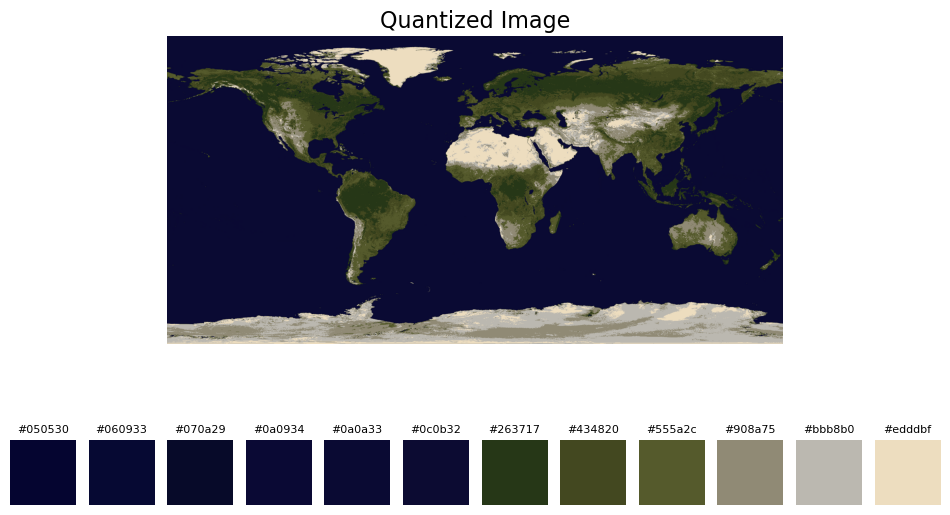

In [41]:
n_colors = 12

# load the image abd convert to RGB
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# apply quantization with Median Cut
quantized_image = image.quantize(method=Image.MEDIANCUT, colors=n_colors).convert('RGB')

# save and display the quantized image
quantized_image.save('figures/bluemarble-2048_downsampled.png')
# img = mpimg.imread('figures/bluemarble-2048_downsampled.png')
# imgplot = plt.imshow(img)
# plt.axis('off')
# plt.show()

## show the N colors as subplots with their hexnames as titles

# get the unique colors from the quantized image
unique_colors = np.unique(np.array(quantized_image).reshape(-1, 3), axis=0)

# convert RGB to HEX
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# create the figure and grid layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.5)

# main plot: quantized image
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(quantized_image)
ax_main.axis('off')
ax_main.set_title("Quantized Image", fontsize=16)

# subplots: color swatches
gs_swatch = GridSpecFromSubplotSpec(1, n_colors, subplot_spec=gs[1, 0], wspace=0.2)
for i, (color, hex_color) in enumerate(zip(unique_colors, hex_colors)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')
    ax_swatch.set_title(hex_color, fontsize=8, pad=5)

plt.savefig(f'figures/bluemarble-2048_downsampled_{n_colors}_example.png')
    
plt.show()

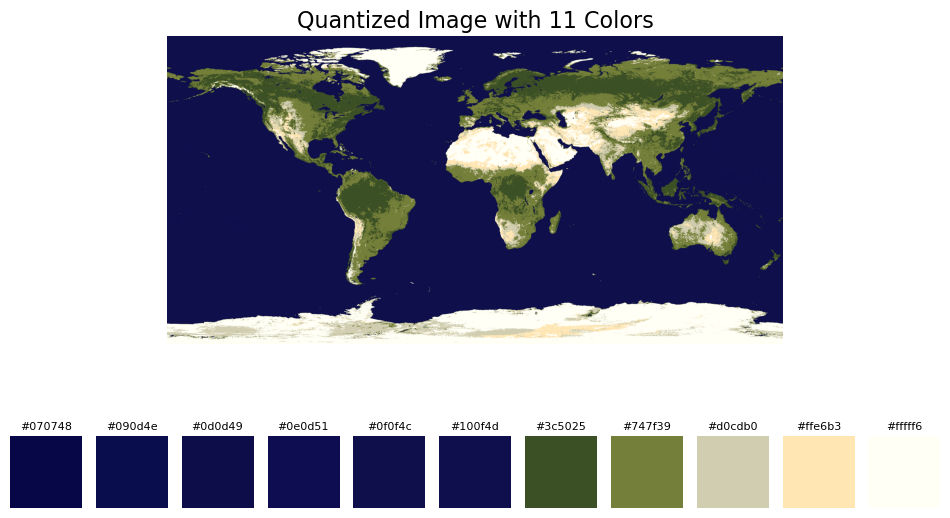

In [49]:
n_colors = 11
brightness_factor = 1.5  # factor to increase brightness; >1.0 makes it brighter

# load the image and convert to RGB
image = Image.open('figures/bluemarble-2048.png').convert("RGB")

# enhance the brightness
enhancer = ImageEnhance.Brightness(image)
brightened_image = enhancer.enhance(brightness_factor)

# apply quantization with Median Cut
quantized_image = brightened_image.quantize(method=Image.MEDIANCUT, colors=n_colors).convert('RGB')

# save and display the quantized image
quantized_image.save('figures/bluemarble-2048_downsampled_brightened.png')

# get the unique colors from the quantized image
unique_colors = np.unique(np.array(quantized_image).reshape(-1, 3), axis=0)

# convert RGB to HEX
hex_colors = ['#%02x%02x%02x' % tuple(color) for color in unique_colors]

# create the figure and grid layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 0.5], hspace=0.5)

# main plot: quantized image
ax_main = fig.add_subplot(gs[0, 0])
ax_main.imshow(quantized_image)
ax_main.axis('off')
ax_main.set_title(f'Quantized Blue Marble Image with {n_colors} Colors', fontsize=16)

# subplots: color swatches
gs_swatch = GridSpecFromSubplotSpec(1, n_colors, subplot_spec=gs[1, 0], wspace=0.2)
for i, (color, hex_color) in enumerate(zip(unique_colors, hex_colors)):
    ax_swatch = fig.add_subplot(gs_swatch[0, i])
    ax_swatch.imshow([[color / 255]])  # Normalize RGB to [0, 1]
    ax_swatch.axis('off')
    ax_swatch.set_title(hex_color, fontsize=8, pad=5)

# save the plot
plt.savefig(f'figures/bluemarble-2048_downsampled_{n_colors}_brightened_example.png')

plt.show()